# **Proyecto #1 - Curso de Teoría de la Simulación**
Impartido por el Ing. Uayeb Cabayero   

Elaborado por:
* Jeimie Vanessa Herrera
* Kattherine Mayely Hernandez  

Presentado el 3 de abril del 2025

**Objetivo**  
Simular un nuevo dataset aplicando técnicas similares a las vistas en el notebook
de referencia. Fortalecer habilidades en limpieza, expansión de datos y análisis
exploratorio de datos (EDA) para extraer patrones valiosos tanto del dataset
original como del expandido.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from decimal import Decimal, getcontext

In [2]:
#from google.colab import drive

#drive.mount('/content/drive')

In [3]:
# df = pd.read_csv("/content/Food_Delivery_Times.csv")

In [4]:
df = pd.read_csv("Food_Delivery_Times.csv")

## 1. Dataset elegido: **Food Delivery Times**

> Documentación referente al dataset en:  https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction

Este dataset está diseñado para predecir los tiempos de entrega de alimentos en función de varios factores influyentes, como la distancia, el clima, las condiciones del tráfico y la hora del día.

*Características principales:*

* Order_ID: Identificador único para cada pedido.

* Distance_km: La distancia de entrega en kilómetros.
* Clima: Condiciones climáticas durante la entrega,
incluyendo Despejado, Lluvioso, Nevado, Nublado y Ventoso.
* Traffic_Level: Condiciones de tráfico         categorizadas como Baja, Media o Alta.
* Time_of_Day: La hora en que se realizó la entrega, categorizada como Mañana, Tarde, Noche o Noche.
* Vehicle_Type: Tipo de vehículo utilizado para la entrega, incluyendo bicicleta, scooter y coche.
* Preparation_Time_min: El tiempo necesario para preparar el pedido, medido en minutos.
* Courier_Experience_yrs: Experiencia del mensajero en años.
* Delivery_Time_min: El tiempo total de entrega en minutos.





















In [5]:
df.head(2)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84


### Especificación de columnas categóricas y numéricas

In [6]:
df.dtypes

Order_ID                    int64
Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object

Se cambia el nombre de las columnas para que sea más manejable a nivel de código.

In [7]:
df.columns = ["order" , "distance" , "weather", "traffic_level" , "time_day" , "vehicle_type" , "preparation_time_min", "experience_years", "delivery_time_min" ]
df_initial = df

In [8]:
df.head(2)

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84


**Columnas categóricas**

In [9]:
cat_cols = []

for c in df.columns:
    if df[c].dtypes == 'object' or df[c].dtypes.name == 'category':
        cat_cols.append(c)

In [10]:
cat_cols

['weather', 'traffic_level', 'time_day', 'vehicle_type']

**Columnas numéricas**

In [11]:
num_cols = []

for c in df.columns:
    if df[c].dtype != 'O':
        num_cols.append(c)

In [12]:
print(num_cols)

['order', 'distance', 'preparation_time_min', 'experience_years', 'delivery_time_min']


---

## 2. **Analísis Exploratorio de Datos** (EDA)

### 2.1 Agrupamos la info para empezar a obtener los valores probabilisticos

Obtenemos cuántas órdenes se comportan de una manera en específico dentro del dataset.

In [13]:
prob_freq = df.groupby (cat_cols , as_index=False).agg({
    "order": ["count"]
    })
prob_freq.columns = cat_cols + ["order"]

In [14]:
prob_freq

,weather,traffic_level,time_day,vehicle_type,order
0,Clear,High,Afternoon,Bike,11
1,Clear,High,Afternoon,Car,3
2,Clear,High,Afternoon,Scooter,8
3,Clear,High,Evening,Bike,10
4,Clear,High,Evening,Car,5
...,...,...,...,...,...
153,Windy,Medium,Evening,Scooter,2
154,Windy,Medium,Morning,Bike,11
155,Windy,Medium,Morning,Car,2
156,Windy,Medium,Morning,Scooter,5


Se identificaron 158 combinaciones únicas de valores en las columnas categóricas que se están utilizando para agrupar los datos. Cada combinación única de categorías forma un "subgrupo", y el número 158 refleja el total de estos grupos distintos.

### Frecuencia probabilística en función de las variables categóricas del dataset

Actualizamos prb_freq para que en lugar de almacenar la cantidad de incidencias, contenga el porcentaje de aparición de estas.

In [15]:
prob_freq["order"] = prob_freq["order"] / df.shape[0]
prob_freq.head(5)

,weather,traffic_level,time_day,vehicle_type,order
0,Clear,High,Afternoon,Bike,0.011
1,Clear,High,Afternoon,Car,0.003
2,Clear,High,Afternoon,Scooter,0.008
3,Clear,High,Evening,Bike,0.010
4,Clear,High,Evening,Car,0.005


In [16]:

np.sum (prob_freq["order"] / df.shape[0])

np.float64(0.000912)

La suma de todas las probabilidades es 0.9120000000000001
> Se considera bueno porque es cercano a 1.

### 2.2 Limpieza de valores NaN

Se identifican algunos registros con valores NaN, lo cual puede afectar nuestro análisis. Se hará una limpieza de los mismos.

In [17]:

# Este es un caso
df.loc[df["order"] == 814]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
379,814,18.46,Clear,NaN,NaN,Scooter,29,1.0,153


Encontrar registros con valores NaN o null

In [18]:
# Encontrar registros con valores NaN en cualquier columna
registros_sucios = df[df.isna().any(axis=1) | df.isnull().any(axis=1) ]

# Mostrar las filas que tienen al menos un valor NaN
registros_sucios


,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
6,627,9.52,Clear,Low,NaN,Bike,12,1.0,49
14,939,2.80,Clear,High,Morning,Scooter,10,NaN,33
24,211,11.20,Clear,Medium,Morning,Bike,23,NaN,73
42,313,0.99,NaN,Medium,Evening,Bike,15,NaN,32
71,494,4.17,NaN,Low,Evening,Scooter,5,1.0,22
...,...,...,...,...,...,...,...,...,...
974,414,11.68,Clear,NaN,Afternoon,Scooter,25,7.0,70
976,344,8.96,Snowy,NaN,Morning,Car,6,5.0,51
987,331,7.44,Rainy,Low,Evening,Bike,27,NaN,53
988,215,14.39,Rainy,Medium,Morning,Scooter,6,NaN,50


117 registros que contienen valores NaN

Eliminar los registros con valores sucios.

In [19]:
print(f"Hay {df.shape[0]} registros previo a primera limpieza.")

df = df.dropna()
print("Limpiando nulos...")

print(f"Hay {df.shape[0]} registros luego de primera limpieza.")

Hay 1000 registros previo a primera limpieza.
Limpiando nulos...
Hay 883 registros luego de primera limpieza.


### 2.3 Limpieza de outliers


Código correspondiente para hacer algunas pruebas manuales y encontrar outliers

In [20]:
# Filtrar
ordenes_con_tiempo_0 = df[df['delivery_time_min'] > 130]

# Mostrar
ordenes_con_tiempo_0[['order', 'delivery_time_min']]

,order,delivery_time_min
127,446,141


Vemos este, tiene 123 minutos de tiempo de entrega.



In [21]:
df.loc[df["order"] == 948]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
29,948,18.05,Clear,Medium,Evening,Scooter,10,7.0,123


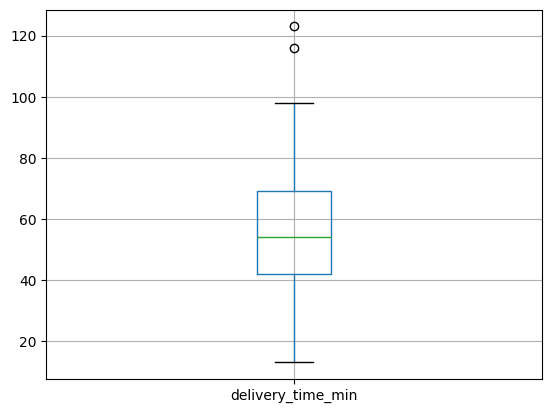

In [22]:
df.loc[
    (df["weather"] == "Clear") &
    (df["traffic_level"] == "Medium") &
    (df["time_day"] == "Evening"	),
    ["delivery_time_min"]
].boxplot()

plt.show()


*delivery_time_min* tiene outliers superiores para este subset específico.

El siguiente es un caso cuyo tiempo de entrega de la orden es 141.

In [23]:
df.loc[df["order"] == 446]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
127,446,18.97,Clear,Low,Evening,Car,25,4.0,141


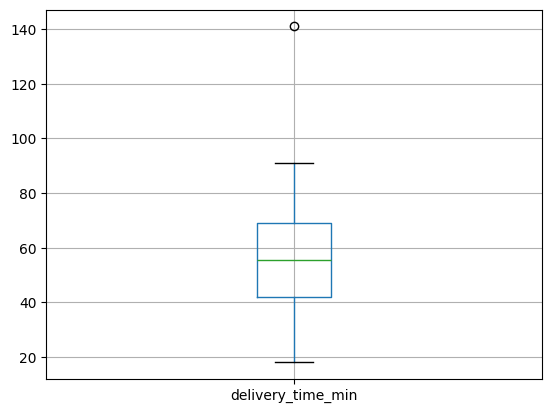

In [24]:
df.loc[
    (df["weather"] == "Clear") &
    (df["traffic_level"] == "Low") &
    (df["time_day"] == "Evening"	),
    ["delivery_time_min"]
].boxplot()

plt.show()

Identificamos que sí hay outliers. Procedemos con su limpieza.

In [25]:
transformations = {}
new_cols = []

for c in num_cols:
    transformations[c] = [
            ( 'lower_bound' , lambda x: x.quantile(.25) - 1.5*(x.quantile(.75) - x.quantile(.25))  )
            , ( 'upper_bound' , lambda x: x.quantile(.75) + 1.5*(x.quantile(.75) - x.quantile(.25))  )
    ]
    new_cols.append( f"{c}_lower_bound" )
    new_cols.append( f"{c}_upper_bound" )

transformations

df_resultados = df.groupby( cat_cols , as_index=False ).agg(transformations)
df_resultados.columns =  cat_cols + new_cols
df_resultados.head(10)

,weather,traffic_level,time_day,vehicle_type,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound
0,Clear,High,Afternoon,Bike,-215.250,1362.750,-14.19500,31.04500,-2.750,35.250,-8.250,17.750,-8.000,112.000
1,Clear,High,Afternoon,Car,-1.000,1363.000,8.67000,12.59000,-4.500,31.500,-4.000,12.000,53.500,61.500
2,Clear,High,Afternoon,Scooter,164.250,1194.250,0.39875,20.56875,-3.750,34.250,-3.125,9.875,24.125,93.125
3,Clear,High,Evening,Bike,26.250,1112.250,-10.10875,25.66125,-13.375,49.625,0.000,8.000,12.875,101.875
4,Clear,High,Evening,Car,-40.000,936.000,0.61500,18.41500,-5.500,38.500,-6.000,18.000,51.000,59.000
5,Clear,High,Evening,Scooter,-304.000,1072.000,4.67000,13.95000,5.500,17.500,-3.000,13.000,22.500,74.500
6,Clear,High,Morning,Bike,-204.000,1430.000,-2.56000,21.82000,-16.500,51.500,-0.625,10.375,14.750,96.750
7,Clear,High,Morning,Car,-589.125,1799.875,2.68125,23.47125,3.875,38.875,-0.875,10.125,37.500,89.500
8,Clear,High,Morning,Scooter,-780.375,1656.625,-7.33250,25.66750,-3.000,37.000,-6.250,15.750,-0.625,112.375
9,Clear,High,Night,Bike,-39.375,1393.625,-1.75000,19.05000,4.500,18.500,1.875,6.875,-8.500,111.500


In [26]:

df_bound = df.merge(
    df_resultados
    , on=cat_cols
    , how="inner"
)

df_bound

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,522.000,522.000,7.9300,7.9300,12.000,12.000,1.000,1.000,43.000,43.000
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,-441.875,1379.125,-9.7625,28.2575,-8.375,40.625,-5.000,11.000,0.500,102.500
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,-216.000,1060.000,5.1850,10.9650,22.000,30.000,0.000,4.000,57.500,59.500
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,-20.500,1077.500,-4.9950,25.5650,-12.625,44.375,-2.375,8.625,-21.125,141.875
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,-331.000,1165.000,-11.7650,28.8350,3.500,31.500,-4.000,12.000,-19.000,117.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,107,8.50,Clear,High,Evening,Car,13,3.0,54,-40.000,936.000,0.6150,18.4150,-5.500,38.500,-6.000,18.000,51.000,59.000
879,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71,-60.500,863.500,-11.1450,24.2550,5.000,13.000,3.000,11.000,0.000,88.000
880,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81,796.500,1054.500,15.1950,16.8950,17.000,29.000,-1.500,12.500,72.000,84.000
881,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55,-554.000,1582.000,-10.4650,25.8950,-5.000,43.000,-8.000,16.000,-24.500,115.500


In [27]:
df_bound.loc[df_bound["order"] == 446]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound
116,446,18.97,Clear,Low,Evening,Car,25,4.0,141,-506.5,1017.5,-3.05,21.03,17.5,29.5,-8.0,16.0,-25.0,135.0


In [28]:
df_bound.loc[df_bound["order"] == 446]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound
116,446,18.97,Clear,Low,Evening,Car,25,4.0,141,-506.5,1017.5,-3.05,21.03,17.5,29.5,-8.0,16.0,-25.0,135.0


In [29]:
df.loc[df["order"] == 446]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
127,446,18.97,Clear,Low,Evening,Car,25,4.0,141


In [30]:
print(f"Hay {df.shape[0]} registros previo a segunda limpieza.")
print("Limpiando outliers...\n")

for c in num_cols:
    print(f" Row: {df_bound.shape[0]} ")
    print(f" {c}: processing... ")

    df_bound = df_bound.loc[
        (df_bound[c] >= df_bound[f"{c}_lower_bound"]) &
        (df_bound[c] <= df_bound[f"{c}_upper_bound"])
    ]

print("Completed!")
print(f"\nHay {df_bound.shape[0]} registros luego de segunda limpieza.")


Hay 883 registros previo a segunda limpieza.
Limpiando outliers...

 Row: 883 
 order: processing... 
 Row: 870 
 distance: processing... 
 Row: 861 
 preparation_time_min: processing... 
 Row: 845 
 experience_years: processing... 
 Row: 830 
 delivery_time_min: processing... 
Completed!

Hay 808 registros luego de segunda limpieza.


In [31]:
df_bound

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,522.000,522.000,7.9300,7.9300,12.000,12.000,1.000,1.000,43.000,43.000
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,-441.875,1379.125,-9.7625,28.2575,-8.375,40.625,-5.000,11.000,0.500,102.500
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,-216.000,1060.000,5.1850,10.9650,22.000,30.000,0.000,4.000,57.500,59.500
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,-20.500,1077.500,-4.9950,25.5650,-12.625,44.375,-2.375,8.625,-21.125,141.875
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,-331.000,1165.000,-11.7650,28.8350,3.500,31.500,-4.000,12.000,-19.000,117.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,107,8.50,Clear,High,Evening,Car,13,3.0,54,-40.000,936.000,0.6150,18.4150,-5.500,38.500,-6.000,18.000,51.000,59.000
879,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71,-60.500,863.500,-11.1450,24.2550,5.000,13.000,3.000,11.000,0.000,88.000
880,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81,796.500,1054.500,15.1950,16.8950,17.000,29.000,-1.500,12.500,72.000,84.000
881,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55,-554.000,1582.000,-10.4650,25.8950,-5.000,43.000,-8.000,16.000,-24.500,115.500


Verificamos nuevamente si aún están los outliers...

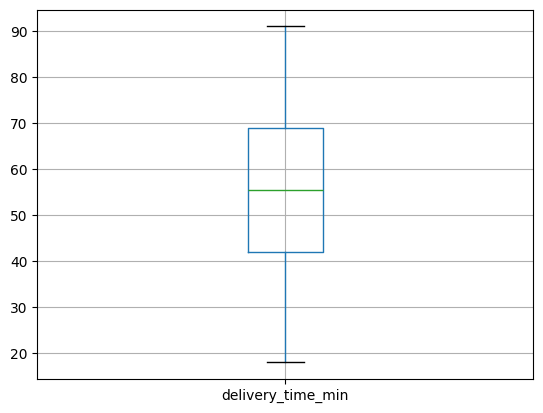

In [32]:
df_bound.loc[
    (df_bound["weather"] == "Clear") &
    (df_bound["traffic_level"] == "Low") &
    (df_bound["time_day"] == "Evening"  ),
    ["delivery_time_min"]
].boxplot()

plt.show()

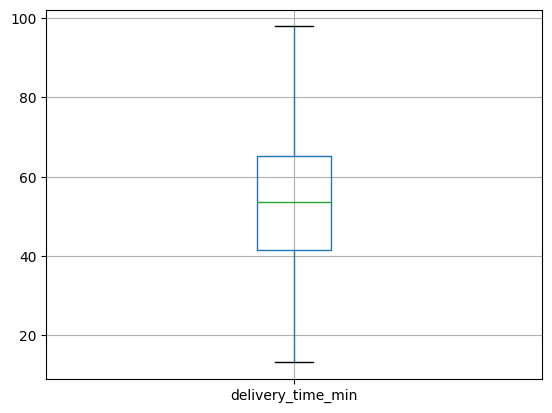

In [33]:
df_bound.loc[
    (df_bound["weather"] == "Clear") &
    (df_bound["traffic_level"] == "Medium") &
    (df_bound["time_day"] == "Evening"  ),
    ["delivery_time_min"]
].boxplot()

plt.show()

Corroboramos que efectivamente los outliers fueron eliminados de dataset.

In [34]:
df_bound.loc[df_bound["order"] == 446]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min,order_lower_bound,order_upper_bound,distance_lower_bound,distance_upper_bound,preparation_time_min_lower_bound,preparation_time_min_upper_bound,experience_years_lower_bound,experience_years_upper_bound,delivery_time_min_lower_bound,delivery_time_min_upper_bound


Intentamos acceder a uno de los registros extremos y ya no existe.

Limpieza completada.

## Resumen estadistico

In [35]:
df_clean = df_bound.loc[:,cat_cols+num_cols]

In [36]:
df_clean.groupby(
    cat_cols, as_index=False
).agg({
    'delivery_time_min':["min","max","mean","std"]
}).head(2)

weather traffic_level   time_day vehicle_type delivery_time_min      \
                                                              min max   
0   Clear          High  Afternoon         Bike                32  95   
1   Clear          High  Afternoon          Car                56  60   

                         
        mean        std  
0  53.909091  21.257726  
1  57.666667   2.081666

In [37]:
summ_aggregations = {}
cols_summ = []
for c in num_cols:
    summ_aggregations[c] = ["min","max","mean","std"]
    cols_summ.append(f"{c}_min")
    cols_summ.append(f"{c}_max")
    cols_summ.append(f"{c}_mean")
    cols_summ.append(f"{c}_std")

In [38]:
summ_aggregations

{'order': ['min', 'max', 'mean', 'std'],
 'distance': ['min', 'max', 'mean', 'std'],
 'preparation_time_min': ['min', 'max', 'mean', 'std'],
 'experience_years': ['min', 'max', 'mean', 'std'],
 'delivery_time_min': ['min', 'max', 'mean', 'std']}

In [39]:
df_summ = df_clean.groupby(
    cat_cols, as_index=False
).agg(summ_aggregations)

In [40]:
df_summ.columns= cat_cols + cols_summ

In [41]:
df_summ

,weather,traffic_level,time_day,vehicle_type,order_min,order_max,order_mean,order_std,distance_min,distance_max,...,preparation_time_min_mean,preparation_time_min_std,experience_years_min,experience_years_max,experience_years_mean,experience_years_std,delivery_time_min_min,delivery_time_min_max,delivery_time_min_mean,delivery_time_min_std
0,Clear,High,Afternoon,Bike,263,977,567.090909,250.226879,0.86,18.80,...,16.727273,7.015567,0.0,9.0,5.090909,3.477198,32,95,53.909091,21.257726
1,Clear,High,Afternoon,Car,287,969,663.333333,346.448168,9.58,11.54,...,14.666667,9.865766,0.0,8.0,4.000000,4.000000,56,60,57.666667,2.081666
2,Clear,High,Afternoon,Scooter,321,964,670.500000,221.377506,1.42,18.07,...,15.000000,7.091242,1.0,9.0,3.875000,3.090885,40,76,58.250000,11.973184
3,Clear,High,Evening,Bike,136,739,506.444444,199.328317,1.51,19.80,...,19.777778,8.105211,0.0,6.0,3.444444,2.006932,34,88,59.333333,16.837458
4,Clear,High,Evening,Car,107,803,479.333333,350.542912,5.83,11.74,...,15.333333,10.692677,3.0,9.0,5.000000,3.464102,54,56,54.666667,1.154701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Windy,Medium,Evening,Scooter,249,956,602.500000,499.924494,7.97,19.29,...,8.000000,1.414214,8.0,8.0,8.000000,0.000000,35,84,59.500000,34.648232
152,Windy,Medium,Morning,Bike,62,865,521.727273,286.827157,2.47,18.20,...,16.727273,8.379629,1.0,9.0,4.818182,2.400757,23,108,58.090909,26.109211
153,Windy,Medium,Morning,Car,640,668,654.000000,19.798990,3.63,7.86,...,22.000000,0.000000,2.0,9.0,5.500000,4.949747,39,55,47.000000,11.313708
154,Windy,Medium,Morning,Scooter,25,913,371.800000,348.454732,2.76,19.26,...,17.000000,9.137833,3.0,9.0,6.000000,2.236068,22,92,54.800000,26.319195


In [42]:
prob_freq

,weather,traffic_level,time_day,vehicle_type,order
0,Clear,High,Afternoon,Bike,0.011
1,Clear,High,Afternoon,Car,0.003
2,Clear,High,Afternoon,Scooter,0.008
3,Clear,High,Evening,Bike,0.010
4,Clear,High,Evening,Car,0.005
...,...,...,...,...,...
153,Windy,Medium,Evening,Scooter,0.002
154,Windy,Medium,Morning,Bike,0.011
155,Windy,Medium,Morning,Car,0.002
156,Windy,Medium,Morning,Scooter,0.005


In [43]:
prob_freq = prob_freq.loc[df_summ.index]  # Solo índices de 0 a 9
prob_freq["order"] /= prob_freq["order"].sum()  # Reajustar probabilidades

ids = np.random.choice(prob_freq.index, size=100000, p=prob_freq["order"].to_list())

In [44]:
len (ids [ids == 0])

1206

In [45]:
len (ids)

100000

In [46]:
len (ids [ids == 0]) / len (ids)

0.01206

In [47]:
df_summ

,weather,traffic_level,time_day,vehicle_type,order_min,order_max,order_mean,order_std,distance_min,distance_max,...,preparation_time_min_mean,preparation_time_min_std,experience_years_min,experience_years_max,experience_years_mean,experience_years_std,delivery_time_min_min,delivery_time_min_max,delivery_time_min_mean,delivery_time_min_std
0,Clear,High,Afternoon,Bike,263,977,567.090909,250.226879,0.86,18.80,...,16.727273,7.015567,0.0,9.0,5.090909,3.477198,32,95,53.909091,21.257726
1,Clear,High,Afternoon,Car,287,969,663.333333,346.448168,9.58,11.54,...,14.666667,9.865766,0.0,8.0,4.000000,4.000000,56,60,57.666667,2.081666
2,Clear,High,Afternoon,Scooter,321,964,670.500000,221.377506,1.42,18.07,...,15.000000,7.091242,1.0,9.0,3.875000,3.090885,40,76,58.250000,11.973184
3,Clear,High,Evening,Bike,136,739,506.444444,199.328317,1.51,19.80,...,19.777778,8.105211,0.0,6.0,3.444444,2.006932,34,88,59.333333,16.837458
4,Clear,High,Evening,Car,107,803,479.333333,350.542912,5.83,11.74,...,15.333333,10.692677,3.0,9.0,5.000000,3.464102,54,56,54.666667,1.154701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Windy,Medium,Evening,Scooter,249,956,602.500000,499.924494,7.97,19.29,...,8.000000,1.414214,8.0,8.0,8.000000,0.000000,35,84,59.500000,34.648232
152,Windy,Medium,Morning,Bike,62,865,521.727273,286.827157,2.47,18.20,...,16.727273,8.379629,1.0,9.0,4.818182,2.400757,23,108,58.090909,26.109211
153,Windy,Medium,Morning,Car,640,668,654.000000,19.798990,3.63,7.86,...,22.000000,0.000000,2.0,9.0,5.500000,4.949747,39,55,47.000000,11.313708
154,Windy,Medium,Morning,Scooter,25,913,371.800000,348.454732,2.76,19.26,...,17.000000,9.137833,3.0,9.0,6.000000,2.236068,22,92,54.800000,26.319195


Ajustamos la precisión

In [48]:
getcontext().prec = 50

In [49]:
def trunc_vector(min_val, max_val, media, desv_std, size):
    # Verificar que el tamaño sea válido
    if size <= 0:
        raise ValueError("El tamaño de las muestras debe ser mayor que 0.")

    std = desv_std
    
    # Si la desviación estándar es 0 o NaN, asignamos un valor pequeño
    if not isinstance(desv_std, (int, float)) or desv_std <= 0 or np.isnan(desv_std):
        print(desv_std)
        std = 1e-6  # Evita que la desviación estándar sea cero o NaN
        print(std)

    # Cálculos para obtener los parámetros de la distribución truncada
    a = (min_val - media) / std
    b = (max_val - media) / std
    
    # Generar las muestras aleatorias con truncnorm
    return truncnorm.rvs(a, b, loc=media, scale=std, size=size)

In [50]:
dfextended = pd.DataFrame()

for i in prob_freq.index:
    setting = {"id": ids[ids == i]}
    size = len(ids[ids == i])
    
    if size <= 0:
        print(f"⚠️ Tamaño inválido ({size}) para índice {i}. Saltando...")
        continue
    
    for c in num_cols:
        try:
            min_val = df_summ.iloc[i][f"{c}_min"]
            max_val = df_summ.iloc[i][f"{c}_max"]
            media = df_summ.iloc[i][f"{c}_mean"]
            desv_std = df_summ.iloc[i][f"{c}_std"]
            setting[c] = trunc_vector(min_val, max_val, media, desv_std, size)
        except ValueError as e:
            print(f"❌ Error en trunc_vector para índice {i}, columna {c}")
            continue
    
    tmp = pd.DataFrame(setting)
    dfextended = pd.concat([dfextended, tmp], ignore_index=True)

nan
1e-06
❌ Error en trunc_vector para índice 21, columna order
nan
1e-06
❌ Error en trunc_vector para índice 21, columna distance
nan
1e-06
❌ Error en trunc_vector para índice 21, columna preparation_time_min
nan
1e-06
❌ Error en trunc_vector para índice 21, columna experience_years
nan
1e-06
❌ Error en trunc_vector para índice 21, columna delivery_time_min
nan
1e-06
❌ Error en trunc_vector para índice 36, columna order
nan
1e-06
❌ Error en trunc_vector para índice 36, columna distance
nan
1e-06
❌ Error en trunc_vector para índice 36, columna preparation_time_min
nan
1e-06
❌ Error en trunc_vector para índice 36, columna experience_years
nan
1e-06
❌ Error en trunc_vector para índice 36, columna delivery_time_min
nan
1e-06
❌ Error en trunc_vector para índice 39, columna order
nan
1e-06
❌ Error en trunc_vector para índice 39, columna distance
nan
1e-06
❌ Error en trunc_vector para índice 39, columna preparation_time_min
nan
1e-06
❌ Error en trunc_vector para índice 39, columna experience

Al intentar hacer la extensión, nos damos cuenta de que en algunos de los subsets probabilísticos, la dsviación estándar está llegando NaN. A continuación analizamos algunos casos.

In [51]:
# 21
df_summ.iloc[21]

weather                      Clear
traffic_level                  Low
time_day                     Night
vehicle_type                   Car
order_min                       68
order_max                       68
order_mean                    68.0
order_std                      NaN
distance_min                 16.14
distance_max                 16.14
distance_mean                16.14
distance_std                   NaN
preparation_time_min_min         6
preparation_time_min_max         6
preparation_time_min_mean      6.0
preparation_time_min_std       NaN
experience_years_min           9.0
experience_years_max           9.0
experience_years_mean          9.0
experience_years_std           NaN
delivery_time_min_min           65
delivery_time_min_max           65
delivery_time_min_mean        65.0
delivery_time_min_std          NaN
Name: 21, dtype: object

In [52]:
# Estos son los registros que se encuentran en el subset 21
df.loc[
    (df['weather'] == 'Clear') & 
    (df['traffic_level'] == 'Low') & 
    (df['time_day'] == 'Night') & 
    (df['vehicle_type'] == 'Car')
]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
83,68,16.14,Clear,Low,Night,Car,6,9.0,65


Solo hay un registro, lo que hace sentido de que el mínimo y el máximo sean lo mismo y no exista desviación estándar.

Revisamos otro de los casos...

In [53]:
# 142
df_summ.iloc[142]

weather                        Windy
traffic_level                    Low
time_day                     Evening
vehicle_type                 Scooter
order_min                        855
order_max                        855
order_mean                     855.0
order_std                        NaN
distance_min                     4.5
distance_max                     4.5
distance_mean                    4.5
distance_std                     NaN
preparation_time_min_min          20
preparation_time_min_max          20
preparation_time_min_mean       20.0
preparation_time_min_std         NaN
experience_years_min             6.0
experience_years_max             6.0
experience_years_mean            6.0
experience_years_std             NaN
delivery_time_min_min             32
delivery_time_min_max             32
delivery_time_min_mean          32.0
delivery_time_min_std            NaN
Name: 142, dtype: object

In [54]:
# Estos son los registros que se encuentran en el subset 142
df.loc[
    (df['weather'] == 'Windy') & 
    (df['traffic_level'] == 'Low') & 
    (df['time_day'] == 'Evening') & 
    (df['vehicle_type'] == 'Scooter')
]

,order,distance,weather,traffic_level,time_day,vehicle_type,preparation_time_min,experience_years,delivery_time_min
651,855,4.5,Windy,Low,Evening,Scooter,20,6.0,32


También contiene solo un registro, lo que nos lleva a la conclusión de que resuelve la std como NaN porque los valores máximo y mínimo son iguales.

Y hay que reconfigurar de manera que el std en lugar de ser NaN, sea cero como corresponde.

In [55]:
dfextended

,id,order,distance,preparation_time_min,experience_years,delivery_time_min
0,0,968.237403,13.926083,12.880056,1.554112,73.522041
1,0,580.072636,12.431911,12.909005,2.144705,72.966481
2,0,505.508530,8.163371,20.244270,2.864307,53.101674
3,0,639.710510,13.510732,17.893124,2.603270,80.681764
4,0,792.714985,12.271575,9.375812,7.249393,64.804672
...,...,...,...,...,...,...
99995,155,533.330940,12.535396,23.561849,4.293620,72.849306
99996,155,708.788734,18.087120,23.873804,4.444494,58.031676
99997,155,735.785185,13.654060,22.184223,6.694523,68.025190
99998,155,643.745887,6.782798,23.909012,8.503557,67.524745


In [56]:
prob_freq["id"] = prob_freq.index

In [57]:
prob_freq.loc[:, ["id"]+ cat_cols].merge(
    dfextended,
    on=["id"],
    how="inner"
)

,id,weather,traffic_level,time_day,vehicle_type,order,distance,preparation_time_min,experience_years,delivery_time_min
0,0,Clear,High,Afternoon,Bike,968.237403,13.926083,12.880056,1.554112,73.522041
1,0,Clear,High,Afternoon,Bike,580.072636,12.431911,12.909005,2.144705,72.966481
2,0,Clear,High,Afternoon,Bike,505.508530,8.163371,20.244270,2.864307,53.101674
3,0,Clear,High,Afternoon,Bike,639.710510,13.510732,17.893124,2.603270,80.681764
4,0,Clear,High,Afternoon,Bike,792.714985,12.271575,9.375812,7.249393,64.804672
...,...,...,...,...,...,...,...,...,...,...
99995,155,Windy,Medium,Morning,Car,533.330940,12.535396,23.561849,4.293620,72.849306
99996,155,Windy,Medium,Morning,Car,708.788734,18.087120,23.873804,4.444494,58.031676
99997,155,Windy,Medium,Morning,Car,735.785185,13.654060,22.184223,6.694523,68.025190
99998,155,Windy,Medium,Morning,Car,643.745887,6.782798,23.909012,8.503557,67.524745


In [58]:
print(f"Fila {i}, columna {c}:")
print(f"  Min: {df_summ.loc[i, f'{c}_min']}")
print(f"  Max: {df_summ.loc[i, f'{c}_max']}")
print(f"  Media: {df_summ.loc[i, f'{c}_mean']}")
print(f"  Std: {df_summ.loc[i, f'{c}_std']}")


Fila 155, columna delivery_time_min:
  Min: 44
  Max: 77
  Media: 65.0
  Std: 18.24828759089466


In [59]:
print("Valores únicos en ids:", np.unique(ids))
print("Índices en prob_freq:", prob_freq.index)

Valores únicos en ids: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155]
Índices en prob_freq: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155],
      dtype='int64', length=156)


In [60]:
print(f"Total de filas generadas: {len(dfextended)}")

Total de filas generadas: 100000


In [61]:
dfextended

,id,order,distance,preparation_time_min,experience_years,delivery_time_min
0,0,968.237403,13.926083,12.880056,1.554112,73.522041
1,0,580.072636,12.431911,12.909005,2.144705,72.966481
2,0,505.508530,8.163371,20.244270,2.864307,53.101674
3,0,639.710510,13.510732,17.893124,2.603270,80.681764
4,0,792.714985,12.271575,9.375812,7.249393,64.804672
...,...,...,...,...,...,...
99995,155,533.330940,12.535396,23.561849,4.293620,72.849306
99996,155,708.788734,18.087120,23.873804,4.444494,58.031676
99997,155,735.785185,13.654060,22.184223,6.694523,68.025190
99998,155,643.745887,6.782798,23.909012,8.503557,67.524745
